# Implementasi Model Deep Learning CNN dan MLP untuk CIFAR-10 dengan TensorFlow

## Tugas:
1. Buat model Deep learning CNN dan MLP (TensorFlow). Ambil datasets dari tensorflow_datasets
2. Gunakan Matriks Evaluasi (Akurasi, Presisi, Recall, F1Score, AUC, ROC)
3. Beri penjelasan untuk setiap persamaan matematika yang ada.
4. Akurasi pada Training dan Testing Set Minimal Sebesar 75%. Untuk model MLP Vanila bebas mendapat akurasi berapapun
5. Disarankan untuk menggunakan Google Colab dengan T4 GPU atau TPU agar proses pelatihan model menjadi lebih cepat.

In [547]:
# Instalasi library yang diperlukan
!pip install -q tensorflow tensorflow_datasets matplotlib scikit-learn pandas seaborn

# Import library
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix

# Set random seed untuk reproduktibilitas
np.random.seed(42)

In [548]:
# Import TensorFlow Libraries dan cek ketersediaan GPU
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers, callbacks
import tensorflow_datasets as tfds

# Set random seed untuk TensorFlow
tf.random.set_seed(42)

# Cek ketersediaan GPU
print("TensorFlow version:", tf.__version__)
print("GPU tersedia:", tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Untuk menampilkan informasi GPU jika tersedia (dengan penanganan error yang lebih baik)
if len(tf.config.list_physical_devices('GPU')) > 0:
    try:
        # Gunakan command shell untuk mendapatkan info GPU
        !nvidia-smi
    except:
        print("Tidak dapat menampilkan detail GPU, tetapi GPU terdeteksi.")

TensorFlow version: 2.18.0
GPU tersedia: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1
Fri Apr  4 15:18:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   76C    P0             34W /   70W |    4304MiB /  15360MiB |      0%      Default |
|        

## 1. Persiapan Dataset CIFAR-10

CIFAR-10 adalah dataset yang terdiri dari 60.000 gambar berwarna dengan resolusi 32x32 pixel, dibagi menjadi 10 kelas: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, dan truck. Dataset dibagi menjadi 50.000 gambar untuk pelatihan dan 10.000 gambar untuk pengujian.

In [549]:
# Memuat dataset CIFAR-10 dari tensorflow.keras.datasets
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalisasi data
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# One-hot encoding untuk label
train_labels_one_hot = tf.keras.utils.to_categorical(train_labels, 10)
test_labels_one_hot = tf.keras.utils.to_categorical(test_labels, 10)

# Nama kelas CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Menampilkan informasi dataset
print(f"Jumlah data pelatihan: {len(train_images)}")
print(f"Jumlah data pengujian: {len(test_images)}")
print(f"Jumlah kelas: {len(class_names)}")
print(f"Kelas: {class_names}")
print(f"Ukuran gambar: {train_images[0].shape}")

Jumlah data pelatihan: 50000
Jumlah data pengujian: 10000
Jumlah kelas: 10
Kelas: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Ukuran gambar: (32, 32, 3)


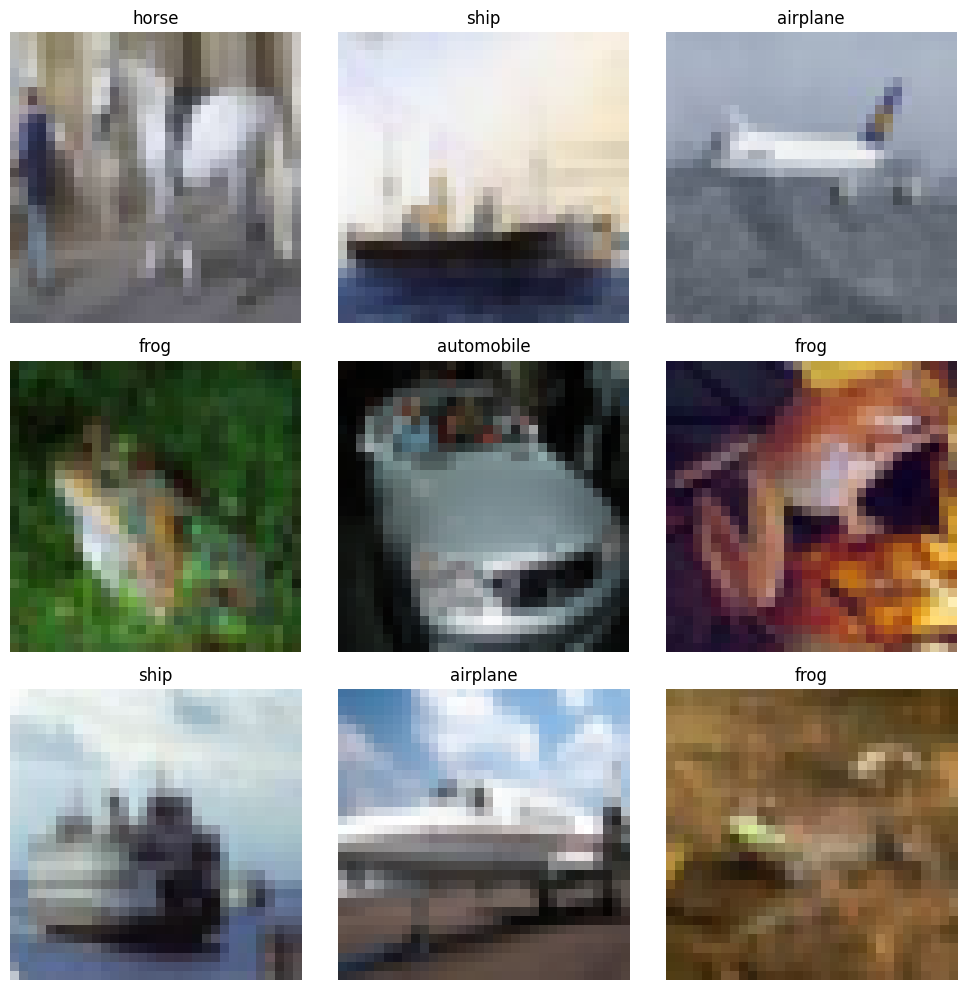

In [550]:
# Visualisasi beberapa gambar dari dataset
def plot_images(images, labels, class_names, grid_size=(3, 3)):
    plt.figure(figsize=(10, 10))
    num_images = grid_size[0] * grid_size[1]
    for i in range(num_images):
        plt.subplot(grid_size[0], grid_size[1], i+1)
        plt.imshow(images[i])
        plt.title(class_names[labels[i][0]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Tampilkan beberapa gambar dari training set
indices = np.random.choice(train_images.shape[0], 9, replace=False)
plot_images(train_images[indices], train_labels[indices], class_names)

## 2. Implementasi Model CNN

### Penjelasan Arsitektur Model CNN:
1. **Convolutional Layers**:
   - Mengekstrak fitur spasial dari gambar
   - Menggunakan kernel 3x3 dengan padding='same' untuk mempertahankan dimensi spasial
   - Meningkatkan jumlah filter (32 → 64 → 128) untuk menangkap fitur yang lebih kompleks

2. **BatchNormalization**:
   - Menstabilkan dan mempercepat pembelajaran dengan menormalkan aktivasi
   - Membantu mengatasi masalah internal covariate shift

3. **MaxPooling**:
   - Mengurangi dimensi spasial (downsampling)
   - Membantu mencapai invariansi translasi

4. **Fully Connected Layers**:
   - Mengklasifikasikan fitur yang diekstrak
   - Layer terakhir memiliki 10 neuron (sesuai jumlah kelas CIFAR-10)

5. **Dropout**:
   - Mencegah overfitting dengan menonaktifkan neuron secara acak selama pelatihan
   - Probabilitas dropout 0.25 (25% neuron dinonaktifkan)

In [551]:
# Model CNN dengan TensorFlow
def create_cnn_model():
    model = models.Sequential([
        # Convolutional layers
        layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Flatten dan Fully Connected layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.25),
        layers.Dense(10, activation='softmax')
    ])

    # Compile model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Inisialisasi model CNN
cnn_model = create_cnn_model()

# Tampilkan ringkasan model
cnn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_84 (Conv2D)                   │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_84               │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_84 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_85 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_85               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_85 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_86 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_86               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_86 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_56 (Flatten)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_140 (Dense)                    │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_84 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_141 (Dense)                    │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,148,362 (4.38 MB)

 Trainable params: 1,147,914 (4.38 MB)

 Non-trainable params: 448 (1.75 KB)

## 3. Implementasi Model MLP (Multi-Layer Perceptron)

### Penjelasan Arsitektur Model MLP:
1. **Flatten Layer**:
   - Mengubah input gambar 32x32x3 menjadi vektor 1D (3072 elemen)

2. **Fully Connected Layers**:
   - Lapisan pertama: 3072 → 1024 neuron
   - Lapisan kedua: 1024 → 512 neuron
   - Lapisan output: 512 → 10 neuron (sesuai jumlah kelas CIFAR-10)

3. **ReLU Activation**:
   - Fungsi aktivasi non-linear pada hidden layers
   - Memungkinkan jaringan mempelajari pola kompleks

4. **Dropout**:
   - Mencegah overfitting dengan menonaktifkan 25% neuron secara acak selama pelatihan

In [552]:
# Model MLP (Vanilla) dengan TensorFlow
def create_mlp_model():
    model = models.Sequential([
        # Flatten input
        layers.Flatten(input_shape=(32, 32, 3)),

        # Dense layers
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.25),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.25),
        layers.Dense(10, activation='softmax')
    ])

    # Compile model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Inisialisasi model MLP
mlp_model = create_mlp_model()

# Tampilkan ringkasan model
mlp_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_57 (Flatten)                 │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_142 (Dense)                    │ (None, 1024)                │       3,146,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_85 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_143 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_86 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_144 (Dense)                    │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,676,682 (14.03 MB)

 Trainable params: 3,676,682 (14.03 MB)

 Non-trainable params: 0 (0.00 B)

## 4. Pelatihan dan Evaluasi Model

### Pelatihan Model
- Menggunakan **Categorical Cross Entropy Loss**
- Optimisasi dengan **Adam Optimizer**
- Learning rate default: **0.001**
- Jumlah epoch: **15**
- Validasi menggunakan 10% data training
- Early stopping untuk menghindari overfitting

In [553]:
# Callback untuk early stopping
early_stopping = callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

# Callback untuk model checkpoint
model_checkpoint = callbacks.ModelCheckpoint(
    'cifar10_cnn_tf_best.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# TensorBoard callback
tensorboard = callbacks.TensorBoard(
    log_dir='./logs',
    histogram_freq=1
)

# Callback list
callback_list = [early_stopping, model_checkpoint]

In [554]:
# Fungsi untuk evaluasi model
def evaluate_model(model, X, y, y_one_hot, class_names):
    # Mendapatkan prediksi
    y_pred_prob = model.predict(X)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = y.reshape(-1)

    # Menghitung metrik evaluasi
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    # ROC Curve dan AUC (One-vs-Rest)
    n_classes = len(class_names)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_one_hot[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Menghitung rata-rata AUC
    macro_roc_auc = np.mean(list(roc_auc.values()))
    print(f'Macro ROC AUC: {macro_roc_auc:.4f}')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': macro_roc_auc,
        'confusion_matrix': cm,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc_per_class': roc_auc
    }

## 5. Pelatihan dan Evaluasi Model CNN

In [555]:
# Pelatihan model CNN
print("Training model CNN...")
start_time = time.time()

cnn_history = cnn_model.fit(
    train_images, train_labels_one_hot,
    epochs=15,
    batch_size=128,
    validation_split=0.1,
    callbacks=callback_list,
    verbose=1
)

total_time = time.time() - start_time
print(f'Training selesai dalam {total_time:.2f} detik')

Training model CNN...
Epoch 1/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4242 - loss: 1.8393
Epoch 1: val_accuracy improved from -inf to 0.30880, saving model to cifar10_cnn_tf_best.h5


352/352 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.4245 - loss: 1.8381 - val_accuracy: 0.3088 - val_loss: 2.3810
Epoch 2/15
350/352 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6432 - loss: 1.0051
Epoch 2: val_accuracy improved from 0.30880 to 0.59340, saving model to cifar10_cnn_tf_best.h5


352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6434 - loss: 1.0046 - val_accuracy: 0.5934 - val_loss: 1.1983
Epoch 3/15
345/352 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7226 - loss: 0.7880
Epoch 3: val_accuracy improved from 0.59340 to 0.67540, saving model to cifar10_cnn_tf_best.h5


352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7229 - loss: 0.7872 - val_accuracy: 0.6754 - val_loss: 0.9778
Epoch 4/15
345/352 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7726 - loss: 0.6484
Epoch 4: val_accuracy did not improve from 0.67540
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7728 - loss: 0.6477 - val_accuracy: 0.6402 - val_loss: 1.0834
Epoch 5/15
345/352 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8151 - loss: 0.5248
Epoch 5: val_accuracy did not improve from 0.67540
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8153 - loss: 0.5243 - val_accuracy: 0.6488 - val_loss: 1.1329
Epoch 6/15
345/352 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8520 - loss: 0.4177
Epoch 6: val_accuracy did not improve from 0.67540
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8521 - loss: 0.4174 - val_accuracy: 0.5922 - val_loss: 1.5042
Epoch 7/15
345/352 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8751 - loss: 0.3487
Epoch 7: val_accuracy improved from

352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8753 - loss: 0.3481 - val_accuracy: 0.7384 - val_loss: 0.9671
Epoch 8/15
345/352 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9018 - loss: 0.2745
Epoch 8: val_accuracy did not improve from 0.73840
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9019 - loss: 0.2742 - val_accuracy: 0.7126 - val_loss: 1.0722
Epoch 9/15
345/352 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9239 - loss: 0.2111
Epoch 9: val_accuracy did not improve from 0.73840
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9240 - loss: 0.2109 - val_accuracy: 0.7200 - val_loss: 1.2795
Epoch 10/15
345/352 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9326 - loss: 0.1901
Epoch 10: val_accuracy did not improve from 0.73840
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9327 - loss: 0.1898 - val_accuracy: 0.7204 - val_loss: 1.3756
Epoch 11/15
345/352 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9429 - loss: 0.1611
Epoch 11: val_accuracy improved 

352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9430 - loss: 0.1609 - val_accuracy: 0.7508 - val_loss: 1.1648
Epoch 12/15
345/352 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9508 - loss: 0.1381
Epoch 12: val_accuracy improved from 0.75080 to 0.76900, saving model to cifar10_cnn_tf_best.h5


352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9509 - loss: 0.1381 - val_accuracy: 0.7690 - val_loss: 1.0964
Epoch 13/15
345/352 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9583 - loss: 0.1171
Epoch 13: val_accuracy did not improve from 0.76900
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9582 - loss: 0.1173 - val_accuracy: 0.7186 - val_loss: 1.4389
Epoch 14/15
345/352 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9587 - loss: 0.1188
Epoch 14: val_accuracy did not improve from 0.76900
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9587 - loss: 0.1187 - val_accuracy: 0.7526 - val_loss: 1.2483
Epoch 15/15
345/352 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9639 - loss: 0.1038
Epoch 15: val_accuracy did not improve from 0.76900
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9639 - loss: 0.1039 - val_accuracy: 0.7292 - val_loss: 1.5016
Training selesai dalam 46.80 detik


In [556]:
# Evaluasi model CNN
print("\nEvaluasi model CNN pada data test:")
cnn_metrics = evaluate_model(cnn_model, test_images, test_labels, test_labels_one_hot, class_names)


Evaluasi model CNN pada data test:
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.7512
Precision: 0.7542
Recall: 0.7512
F1 Score: 0.7508
Macro ROC AUC: 0.9666


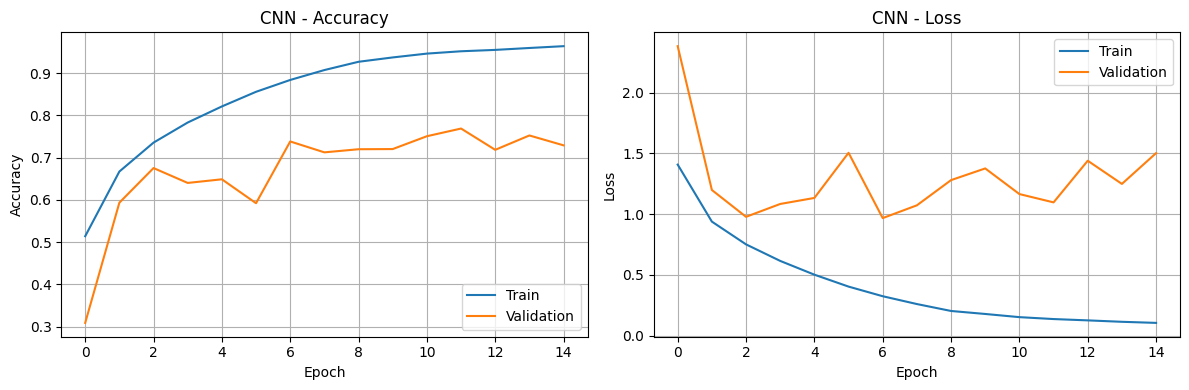

In [557]:
# Fungsi untuk plot hasil training history
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='lower right')
    plt.grid(True)

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Plot hasil training CNN
plot_training_history(cnn_history, "CNN")

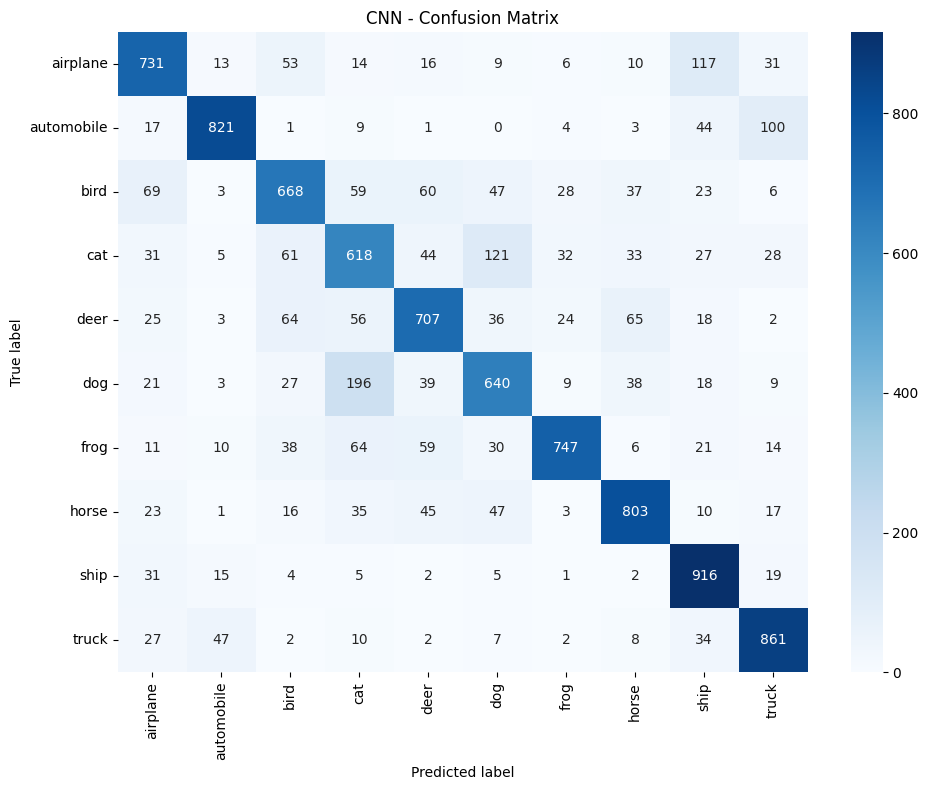

In [558]:
# Fungsi untuk plot confusion matrix
def plot_confusion_matrix(cm, classes, model_name):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Plot confusion matrix CNN
plot_confusion_matrix(cnn_metrics['confusion_matrix'], class_names, "CNN")

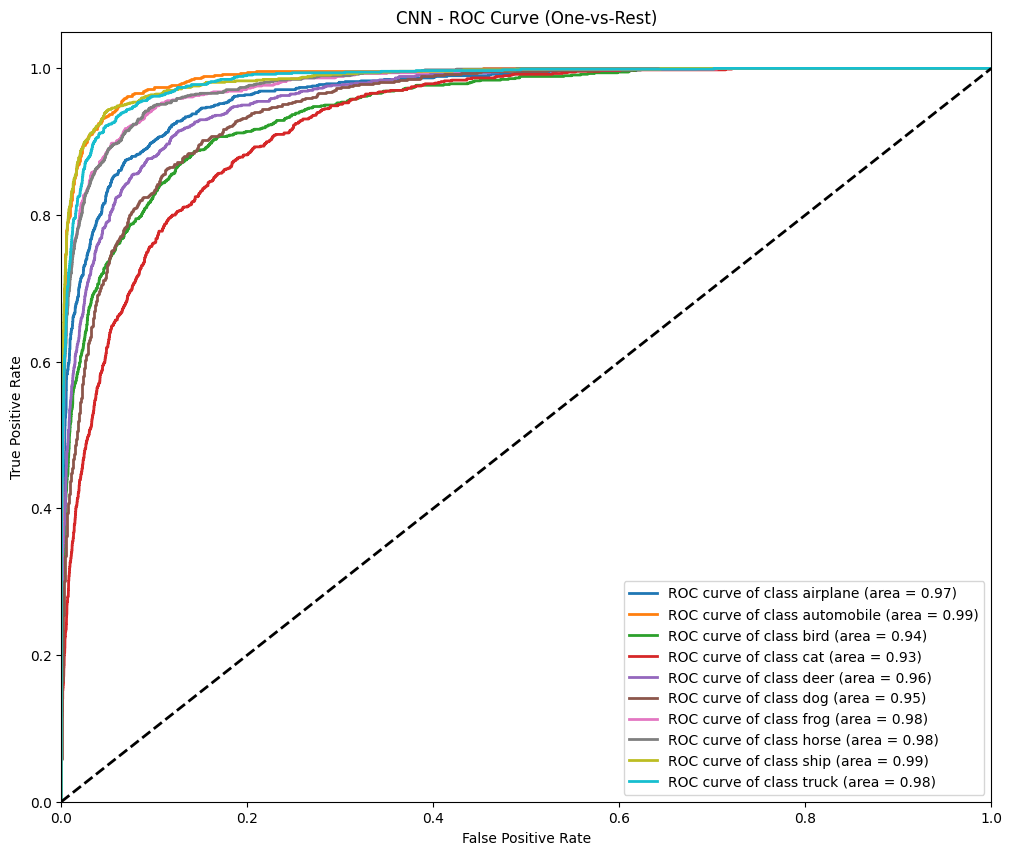

In [559]:
# Fungsi untuk plot ROC curve
def plot_roc_curve(fpr, tpr, roc_auc, classes, model_name):
    plt.figure(figsize=(12, 10))

    # Plot ROC curve untuk setiap kelas
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], lw=2,
                 label=f'ROC curve of class {classes[i]} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curve (One-vs-Rest)')
    plt.legend(loc="lower right")
    plt.show()

# Plot ROC curve CNN
plot_roc_curve(cnn_metrics['fpr'], cnn_metrics['tpr'], cnn_metrics['roc_auc_per_class'], class_names, "CNN")

## 6. Pelatihan dan Evaluasi Model MLP

In [560]:
# Pelatihan model MLP
print("Training model MLP...")
start_time = time.time()

mlp_history = mlp_model.fit(
    train_images, train_labels_one_hot,
    epochs=30,
    batch_size=64,
    validation_split=0.1,
    callbacks=callback_list,
    verbose=1
)

total_time = time.time() - start_time
print(f'Training selesai dalam {total_time:.2f} detik')

Training model MLP...
Epoch 1/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2267 - loss: 2.2072
Epoch 1: val_accuracy did not improve from 0.76900
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.2267 - loss: 2.2069 - val_accuracy: 0.3130 - val_loss: 1.8865
Epoch 2/30
694/704 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3102 - loss: 1.8782
Epoch 2: val_accuracy did not improve from 0.76900
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3103 - loss: 1.8779 - val_accuracy: 0.3536 - val_loss: 1.8027
Epoch 3/30
696/704 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3340 - loss: 1.8187
Epoch 3: val_accuracy did not improve from 0.76900
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3340 - loss: 1.8186 - val_accuracy: 0.3632 - val_loss: 1.7864
Epoch 4/30
701/704 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3468 - loss: 1.7954
Epoch 4: val_accuracy did not improve from 0.76900
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3468 - loss: 1.7953 - va


Evaluasi model MLP pada data test:
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 0.4501
Precision: 0.4502
Recall: 0.4501
F1 Score: 0.4378
Macro ROC AUC: 0.8605


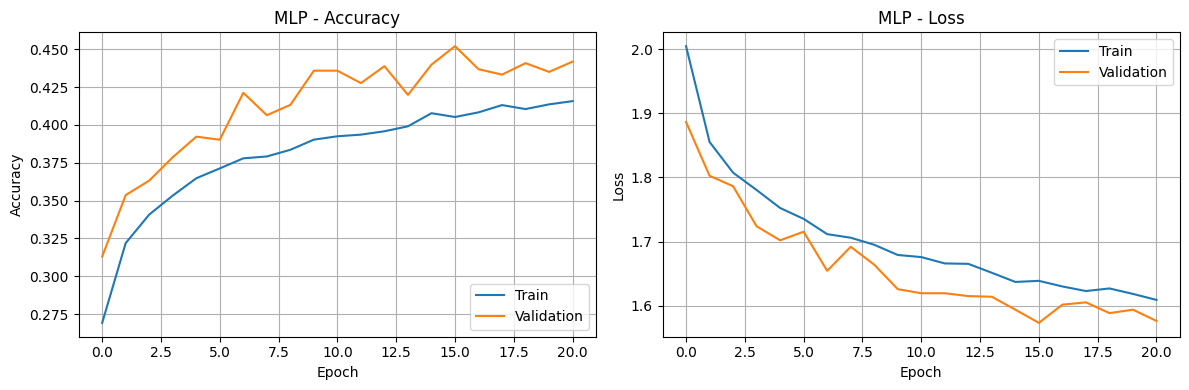

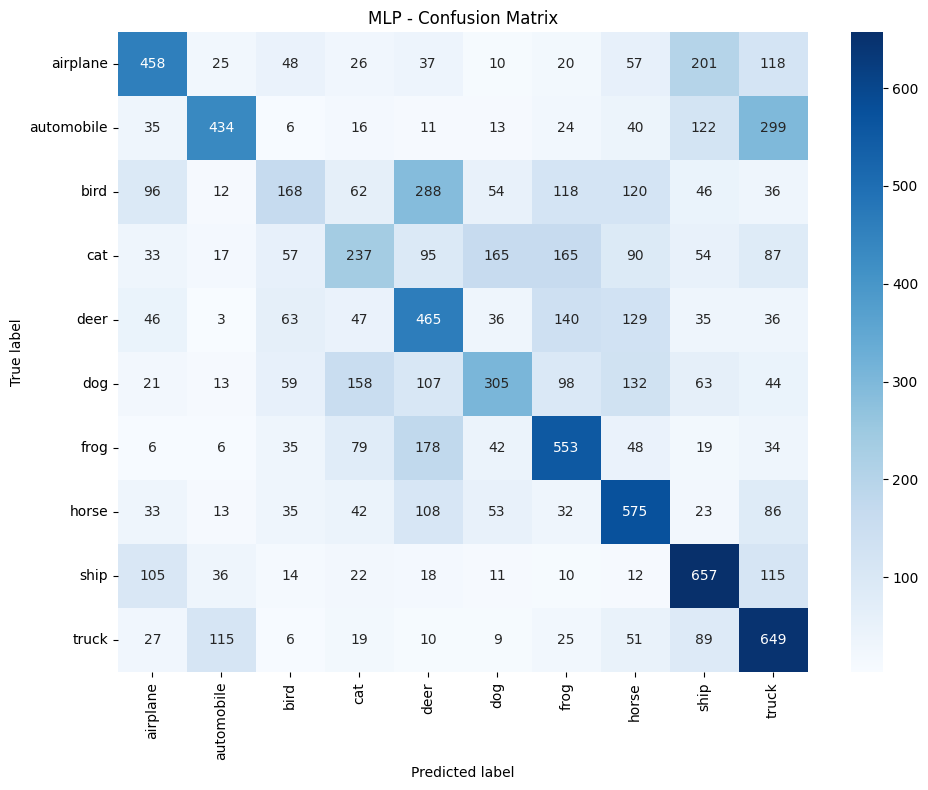

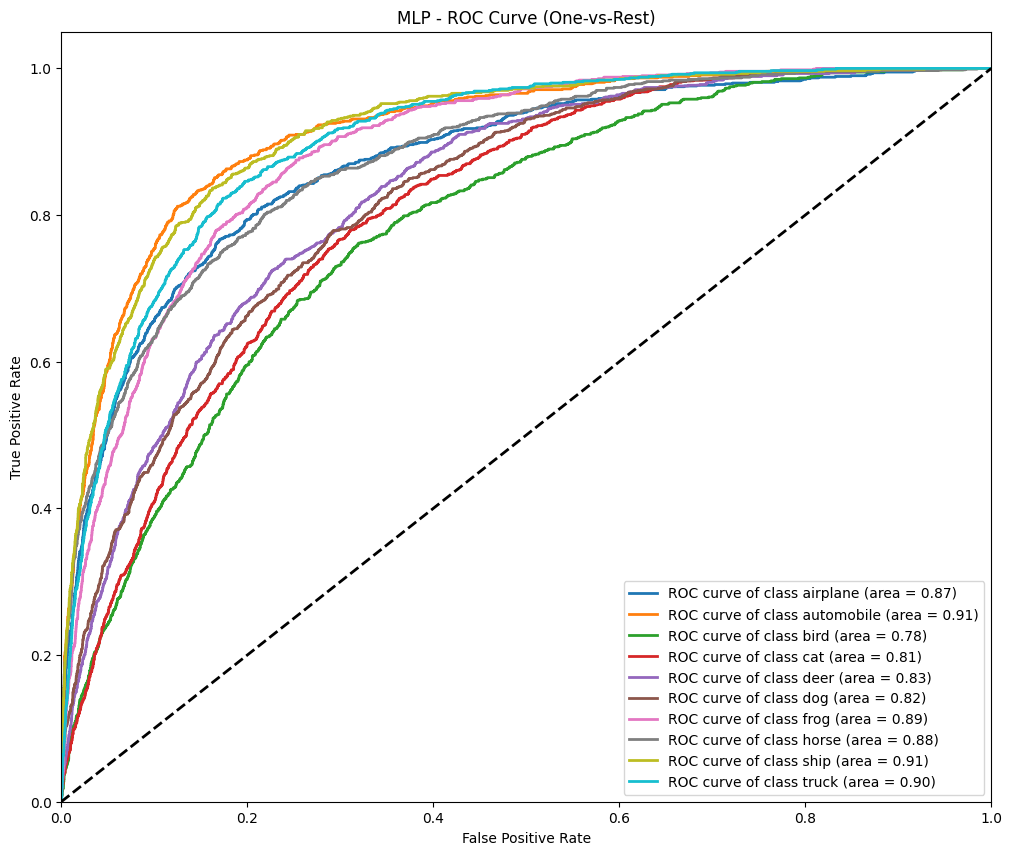

In [561]:
# Evaluasi model MLP
print("\nEvaluasi model MLP pada data test:")
mlp_metrics = evaluate_model(mlp_model, test_images, test_labels, test_labels_one_hot, class_names)

# Plot hasil training MLP
plot_training_history(mlp_history, "MLP")

# Plot confusion matrix MLP
plot_confusion_matrix(mlp_metrics['confusion_matrix'], class_names, "MLP")

# Plot ROC curve MLP
plot_roc_curve(mlp_metrics['fpr'], mlp_metrics['tpr'], mlp_metrics['roc_auc_per_class'], class_names, "MLP")

## 7. Perbandingan Hasil CNN vs MLP

In [562]:
# Perbandingan metrik CNN vs MLP
print("Perbandingan Model CNN vs MLP untuk CIFAR-10:")
metrics_comparison = {
    'Metrik': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'],
    'CNN': [
        f"{cnn_metrics['accuracy']:.4f}",
        f"{cnn_metrics['precision']:.4f}",
        f"{cnn_metrics['recall']:.4f}",
        f"{cnn_metrics['f1']:.4f}",
        f"{cnn_metrics['roc_auc']:.4f}"
    ],
    'MLP': [
        f"{mlp_metrics['accuracy']:.4f}",
        f"{mlp_metrics['precision']:.4f}",
        f"{mlp_metrics['recall']:.4f}",
        f"{mlp_metrics['f1']:.4f}",
        f"{mlp_metrics['roc_auc']:.4f}"
    ]
}

# Membuat DataFrame untuk perbandingan
metrics_df = pd.DataFrame(metrics_comparison)
print(metrics_df)

Perbandingan Model CNN vs MLP untuk CIFAR-10:
      Metrik     CNN     MLP
0   Accuracy  0.7512  0.4501
1  Precision  0.7542  0.4502
2     Recall  0.7512  0.4501
3   F1 Score  0.7508  0.4378
4    ROC AUC  0.9666  0.8605


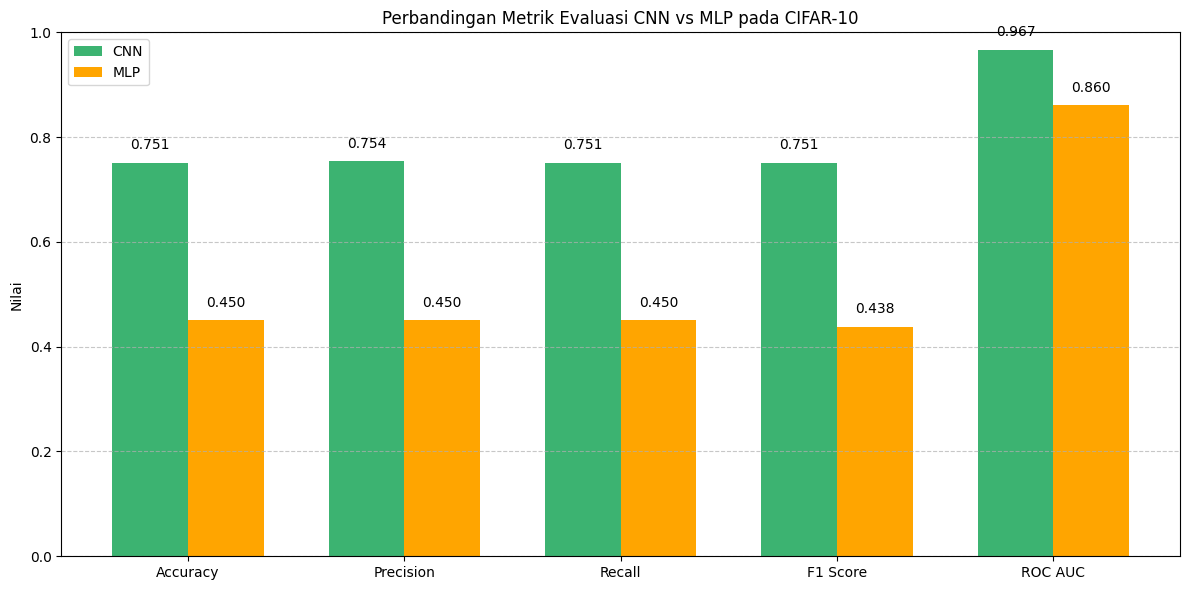

In [563]:
# Visualisasi perbandingan metrik dengan barplot
plt.figure(figsize=(12, 6))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
cnn_values = [cnn_metrics['accuracy'], cnn_metrics['precision'],
              cnn_metrics['recall'], cnn_metrics['f1'], cnn_metrics['roc_auc']]
mlp_values = [mlp_metrics['accuracy'], mlp_metrics['precision'],
              mlp_metrics['recall'], mlp_metrics['f1'], mlp_metrics['roc_auc']]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, cnn_values, width, label='CNN', color='mediumseagreen')
plt.bar(x + width/2, mlp_values, width, label='MLP', color='orange')

plt.ylabel('Nilai')
plt.title('Perbandingan Metrik Evaluasi CNN vs MLP pada CIFAR-10')
plt.xticks(x, metrics)
plt.ylim(0, 1.0)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Menambahkan nilai di atas bar
for i, v in enumerate(cnn_values):
    plt.text(i - width/2, v + 0.02, f'{v:.3f}', ha='center', va='bottom')
for i, v in enumerate(mlp_values):
    plt.text(i + width/2, v + 0.02, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 8. Analisis Per-Kelas

In [564]:
# Fungsi untuk menghitung performa per kelas dari confusion matrix
def get_per_class_metrics(cm, classes):
    n_classes = len(classes)
    precision_per_class = np.zeros(n_classes)
    recall_per_class = np.zeros(n_classes)
    f1_per_class = np.zeros(n_classes)

    for i in range(n_classes):
        # True positives: diagonal elements
        tp = cm[i, i]
        # False positives: sum of column i - tp
        fp = np.sum(cm[:, i]) - tp
        # False negatives: sum of row i - tp
        fn = np.sum(cm[i, :]) - tp

        # Precision: tp / (tp + fp)
        precision_per_class[i] = tp / (tp + fp) if (tp + fp) > 0 else 0
        # Recall: tp / (tp + fn)
        recall_per_class[i] = tp / (tp + fn) if (tp + fn) > 0 else 0
        # F1 score: 2 * (precision * recall) / (precision + recall)
        f1_per_class[i] = 2 * (precision_per_class[i] * recall_per_class[i]) / (precision_per_class[i] + recall_per_class[i]) if (precision_per_class[i] + recall_per_class[i]) > 0 else 0

    return precision_per_class, recall_per_class, f1_per_class

# Menghitung metrik per kelas untuk CNN
cnn_precision_per_class, cnn_recall_per_class, cnn_f1_per_class = get_per_class_metrics(cnn_metrics['confusion_matrix'], class_names)

# Menghitung metrik per kelas untuk MLP
mlp_precision_per_class, mlp_recall_per_class, mlp_f1_per_class = get_per_class_metrics(mlp_metrics['confusion_matrix'], class_names)

# Membuat DataFrame untuk perbandingan per kelas
per_class_comparison ={
    'Class': class_names,
    'CNN Precision': cnn_precision_per_class,
    'MLP Precision': mlp_precision_per_class,
    'CNN Recall': cnn_recall_per_class,
    'MLP Recall': mlp_recall_per_class,
    'CNN F1': cnn_f1_per_class,
    'MLP F1': mlp_f1_per_class,
    'CNN AUC': [cnn_metrics['roc_auc_per_class'][i] for i in range(len(class_names))],
    'MLP AUC': [mlp_metrics['roc_auc_per_class'][i] for i in range(len(class_names))]
}

per_class_df = pd.DataFrame(per_class_comparison)
per_class_df = per_class_df.round(4)
print(per_class_df)

        Class  CNN Precision  MLP Precision  CNN Recall  MLP Recall  CNN F1  \
0    airplane         0.7414         0.5326       0.731       0.458  0.7362   
1  automobile         0.8914         0.6439       0.821       0.434  0.8548   
2        bird         0.7152         0.3422       0.668       0.168  0.6908   
3         cat         0.5797         0.3347       0.618       0.237  0.5983   
4        deer         0.7251         0.3531       0.707       0.465  0.7159   
5         dog         0.6794         0.4370       0.640       0.305  0.6591   
6        frog         0.8727         0.4667       0.747       0.553  0.8050   
7       horse         0.7990         0.4585       0.803       0.575  0.8010   
8        ship         0.7459         0.5019       0.916       0.657  0.8223   
9       truck         0.7921         0.4315       0.861       0.649  0.8251   

   MLP F1  CNN AUC  MLP AUC  
0  0.4925   0.9669   0.8734  
1  0.5185   0.9888   0.9137  
2  0.2254   0.9449   0.7839  
3  0.2775 

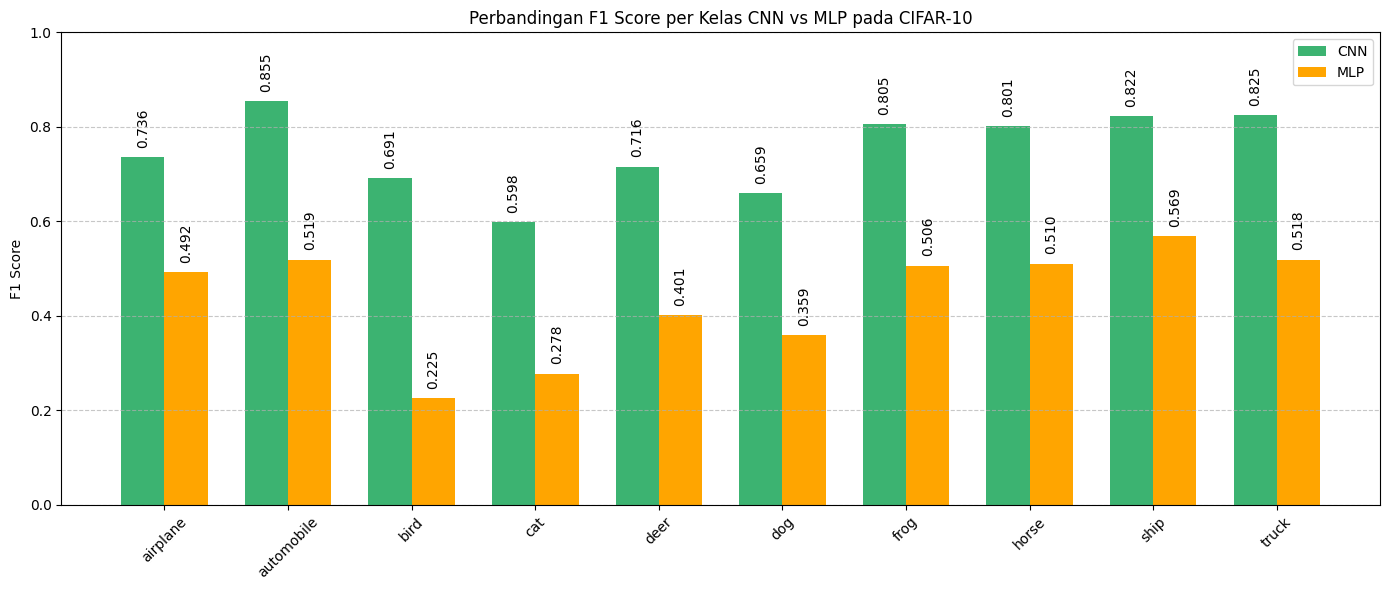

In [565]:
# Visualisasi perbandingan F1 Score per kelas
plt.figure(figsize=(14, 6))

x = np.arange(len(class_names))
width = 0.35

plt.bar(x - width/2, cnn_f1_per_class, width, label='CNN', color='mediumseagreen')
plt.bar(x + width/2, mlp_f1_per_class, width, label='MLP', color='orange')

plt.ylabel('F1 Score')
plt.title('Perbandingan F1 Score per Kelas CNN vs MLP pada CIFAR-10')
plt.xticks(x, class_names, rotation=45)
plt.ylim(0, 1.0)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Menambahkan nilai di atas bar
for i, v in enumerate(cnn_f1_per_class):
    plt.text(i - width/2, v + 0.02, f'{v:.3f}', ha='center', va='bottom', rotation=90)
for i, v in enumerate(mlp_f1_per_class):
    plt.text(i + width/2, v + 0.02, f'{v:.3f}', ha='center', va='bottom', rotation=90)

plt.tight_layout()
plt.show()

## 9. Visualisasi Prediksi

Visualisasi Prediksi CNN:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


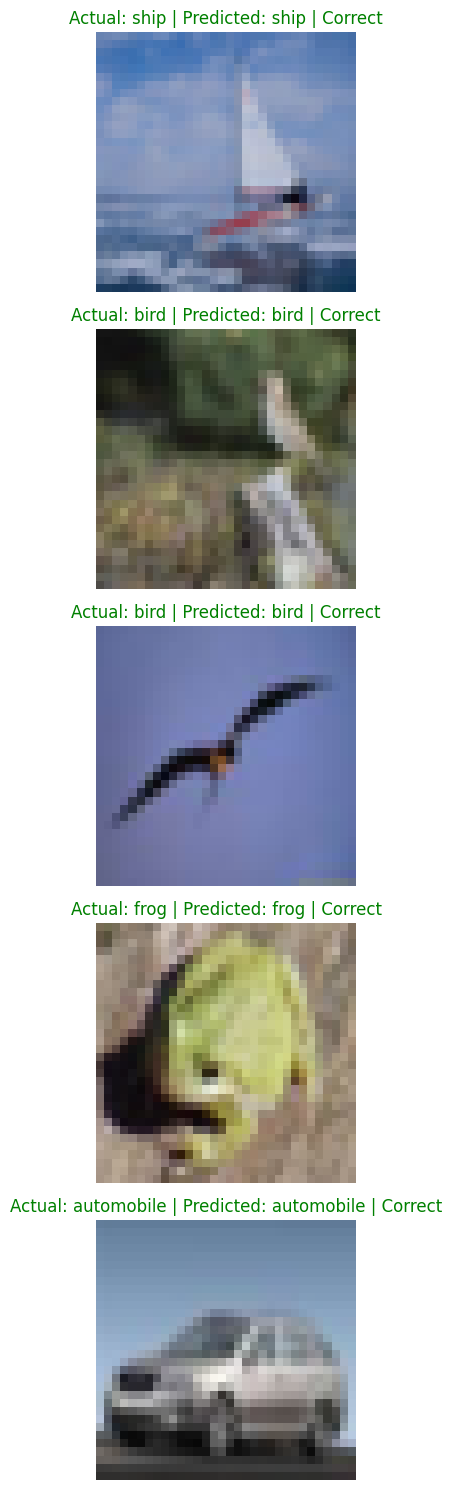


Visualisasi Prediksi MLP:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


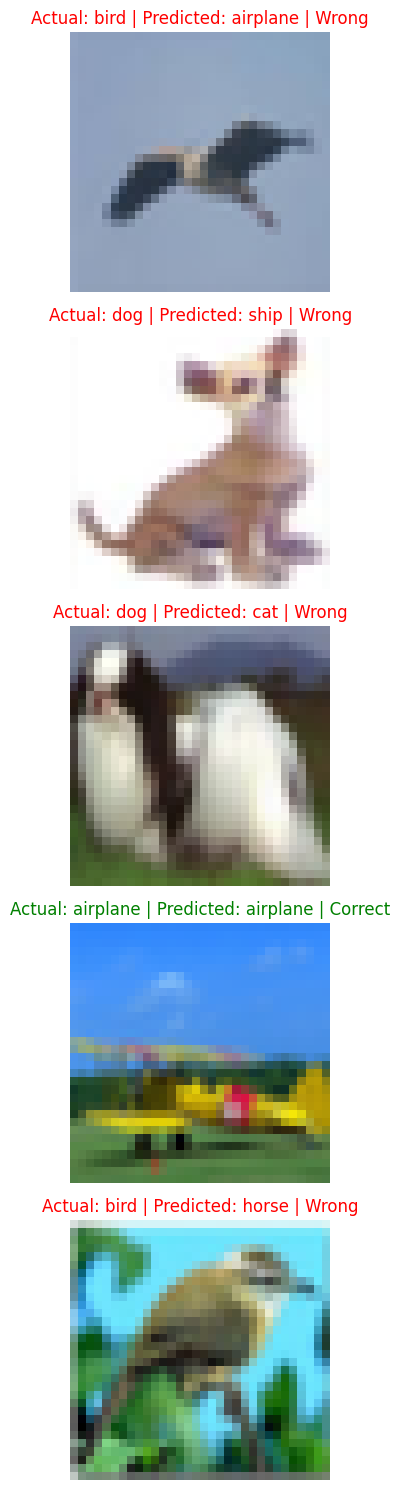

In [566]:
# Fungsi untuk visualisasi prediksi pada beberapa gambar
def visualize_predictions(model, X_test, y_test, class_names, num_images=5):
    # Pilih indeks acak
    indices = np.random.choice(len(X_test), num_images, replace=False)

    # Mendapatkan gambar dan label
    images = X_test[indices]
    true_labels = y_test[indices].reshape(-1)

    # Mendapatkan prediksi
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)

    # Tampilkan gambar dan prediksi
    plt.figure(figsize=(12, 3*num_images))
    for i in range(num_images):
        plt.subplot(num_images, 1, i+1)
        plt.imshow(images[i])
        plt.title(f'Actual: {class_names[true_labels[i]]} | Predicted: {class_names[predicted_labels[i]]} | ' +
                  ('Correct' if predicted_labels[i] == true_labels[i] else 'Wrong'),
                 color='green' if predicted_labels[i] == true_labels[i] else 'red')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualisasi prediksi CNN
print("Visualisasi Prediksi CNN:")
visualize_predictions(cnn_model, test_images, test_labels, class_names)

# Visualisasi prediksi MLP
print("\nVisualisasi Prediksi MLP:")
visualize_predictions(mlp_model, test_images, test_labels, class_names)

## 10. Penjelasan Persamaan Matematika

Berikut adalah penjelasan persamaan matematika yang digunakan dalam implementasi model CNN dan MLP:

### 1. Konvolusi (Convolution)

Operasi konvolusi dalam CNN dinyatakan sebagai:

$$\textrm{(I * K)(i, j)} = \sum_{m} \sum_{n} \textrm{I(i-m, j-n) K(m, n)}$$

dimana:
- $I$ adalah input image
- $K$ adalah kernel/filter
- $*$ adalah operasi konvolusi
- $i, j$ adalah posisi pada feature map hasil
- $m, n$ adalah posisi pada kernel

Operasi ini menggeser filter/kernel ke seluruh citra input dengan langkah tertentu (stride) untuk mengekstrak fitur. Dalam implementasi TensorFlow, kita menggunakan `layers.Conv2D` dengan kernel 3x3 dan padding='same' untuk mempertahankan dimensi spasial input.

### 2. ReLU (Rectified Linear Unit)

Fungsi aktivasi ReLU yang digunakan dalam model:

$$\textrm{f(x)} = \max(0, x)$$

ReLU menggantikan semua nilai negatif dalam feature map dengan 0, sementara nilai positif tidak berubah. Ini memperkenalkan non-linearitas ke model tanpa mempengaruhi bidang reseptif dalam lapisan konvolusional.

### 3. Max Pooling

Operasi Max Pooling:

$$\textrm{MaxPool(i, j)} = \max_{(p,q) \in R_{ij}} x_{p,q}$$

dimana:
- $R_{ij}$ adalah wilayah pooling (2x2) dengan titik $(i,j)$ sebagai sudut kiri atas
- $x_{p,q}$ adalah nilai di posisi $(p,q)$

Max pooling mengambil nilai maksimum dari region 2x2, yang membantu mengurangi dimensi representasi dan mengurangi jumlah parameter serta komputasi dalam jaringan. Dalam TensorFlow, ini diimplementasikan dengan `layers.MaxPooling2D`.

### 4. Batch Normalization

Batch Normalization dihitung dengan:

$$\hat{x}^{(k)} = \frac{x^{(k)} - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}$$

$$y^{(k)} = \gamma \hat{x}^{(k)} + \beta$$

dimana:
- $x^{(k)}$ adalah input ke layer batch normalization
- $\mu_B$ adalah mean batch
- $\sigma_B^2$ adalah variance batch
- $\epsilon$ adalah konstanta kecil untuk stabilitas numerik
- $\gamma, \beta$ adalah parameter yang dapat dipelajari

Batch normalization (diimplementasikan dengan `layers.BatchNormalization()`) menstabilkan proses pembelajaran dengan menormalkan aktivasi dari lapisan sebelumnya, yang memungkinkan learning rate yang lebih tinggi dan mengurangi masalah vanishing/exploding gradients.

### 5. Fully Connected Layer

Operasi dalam fully connected layer (`layers.Dense`):

$$y = \sigma(Wx + b)$$

dimana:
- $W$ adalah matriks bobot
- $x$ adalah vektor input
- $b$ adalah vektor bias
- $\sigma$ adalah fungsi aktivasi (ReLU dalam kasus ini)
- $y$ adalah output layer

Untuk MLP dalam implementasi kita, input gambar 32x32x3 (3072 pixel) diratakan menjadi vektor dengan `layers.Flatten()`, kemudian diproses melalui beberapa lapisan fully connected.

### 6. Dropout

Selama training, Dropout (`layers.Dropout`) secara acak menonaktifkan neuron dengan probabilitas $p$:

$$\hat{y} = r * y$$

dimana:
- $r$ adalah vektor acak dengan elemen yang diambil dari distribusi Bernoulli dengan probabilitas $(1-p)$
- $y$ adalah output dari layer sebelumnya
- $\hat{y}$ adalah output setelah dropout

Dalam implementasi, kita menggunakan dropout dengan probabilitas 0.25, yang berarti sekitar 25% neuron dinonaktifkan secara acak selama pelatihan untuk mencegah overfitting.

### 7. Categorical Cross-Entropy Loss

Untuk klasifikasi multi-kelas (10 kelas CIFAR-10), fungsi Categorical Cross-Entropy Loss digunakan:

$$L = -\sum_{i=1}^{N} \sum_{c=1}^{C} y_{ic} \log(p_{ic})$$

dimana:
- $N$ adalah jumlah sampel dalam batch
- $C$ adalah jumlah kelas (10 untuk CIFAR-10)
- $y_{ic}$ adalah indikator biner (0 atau 1) jika kelas $c$ adalah label benar untuk sampel $i$
- $p_{ic}$ adalah probabilitas yang diprediksi bahwa sampel $i$ termasuk kelas $c$

Cross-entropy loss adalah ukuran perbedaan antara distribusi probabilitas prediksi dan distribusi sebenarnya. Semakin kecil nilai loss, semakin baik model dalam memprediksi label yang benar.

### 8. Optimizer Adam

Adam (Adaptive Moment Estimation) menggabungkan momentum dan RMSprop:

\begin{align}
m_t &= \beta_1 m_{t-1} + (1 - \beta_1) g_t \\
v_t &= \beta_2 v_{t-1} + (1 - \beta_2) g_t^2 \\
\hat{m}_t &= \frac{m_t}{1 - \beta_1^t} \\
\hat{v}_t &= \frac{v_t}{1 - \beta_2^t} \\
\theta_t &= \theta_{t-1} - \alpha \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}
\end{align}

dimana:
- $g_t$ adalah gradien pada waktu $t$
- $m_t$ adalah estimasi momen pertama (mean)
- $v_t$ adalah estimasi momen kedua (variance)
- $\beta_1, \beta_2$ adalah decay rates untuk estimasi momen (biasanya $\beta_1=0.9, \beta_2=0.999$)
- $\alpha$ adalah learning rate (0.001 dalam implementasi kita)
- $\epsilon$ adalah konstanta kecil untuk stabilitas numerik

Adam memadukan kelebihan dari algoritma optimasi Momentum dan RMSprop, menyesuaikan learning rate untuk setiap parameter jaringan berdasarkan estimasi momen. Dalam TensorFlow, ini diimplementasikan dengan optimizer='adam'.

Persamaan Metrik Evaluasi

Definisi Dasar Klasifikasi

True Positive (TP): Jumlah prediksi positif yang benar

True Negative (TN): Jumlah prediksi negatif yang benar

False Positive (FP): Jumlah prediksi positif yang salah (kesalahan tipe I)

False Negative (FN): Jumlah prediksi negatif yang salah (kesalahan tipe II)

Accuracy (Akurasi)


$$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$$


Proporsi prediksi yang benar dari seluruh prediksi. Baik untuk dataset seimbang.

Accuracy untuk multi-kelas

$$\text{Accuracy} = \frac{\text{Jumlah prediksi yang benar}}{\text{Total jumlah prediksi}}$$


Generalisasi akurasi untuk kasus multi-kelas.

Precision (Presisi)

$$\text{Precision} = \frac{TP}{TP + FP}$$

Proporsi prediksi positif yang benar dari seluruh prediksi positif. Berguna
ketika biaya FP tinggi.

Macro-Precision

$$\text{Macro-Precision} = \frac{1}{C}\sum_{i=1}^{C} \text{Precision}_i$$


Rata-rata precision dari semua kelas, memberikan bobot yang sama untuk setiap kelas.

Recall (Sensitivity)

$$\text{Recall} = \frac{TP}{TP + FN}$$

Proporsi kasus positif yang teridentifikasi dari seluruh kasus positif sebenarnya. Berguna ketika biaya FN tinggi.

Macro-Recall

$$\text{Macro-Recall} = \frac{1}{C}\sum_{i=1}^{C} \text{Recall}_i$$

Rata-rata recall dari semua kelas, memberikan bobot yang sama untuk setiap kelas.

F1 Score

$$\text{F1} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$

Rata-rata harmonik dari precision dan recall. Memberikan keseimbangan antara kedua metrik tersebut.

Macro-F1

$$\text{Macro-F1} = \frac{1}{C}\sum_{i=1}^{C} \text{F1}_i$$

Rata-rata F1 score dari semua kelas.

Specificity (True Negative Rate)

$$\text{Specificity} = \frac{TN}{TN + FP}$$

Proporsi kasus negatif yang teridentifikasi dengan benar dari seluruh kasus negatif.

True Positive Rate (untuk ROC)

$$\text{TPR} = \frac{TP}{TP + FN} = \text{Recall}$$

Sama dengan Recall, mengukur kemampuan model menemukan semua kasus positif.

False Positive Rate (untuk ROC)

$$\text{FPR} = \frac{FP}{FP + TN} = 1 - \text{Specificity}$$

Proporsi kasus negatif yang salah diklasifikasikan sebagai positif.

AUC (Area Under Curve)

$$\text{AUC} = \int_{0}^{1} \text{TPR}(\text{FPR}^{-1}(t)) dt$$

Area di bawah kurva ROC, mengukur kemampuan model untuk membedakan antara kelas. Nilai berkisar dari 0.5 (acak) hingga 1 (sempurna).

Macro-AUC

$$\text{Macro-AUC} = \frac{1}{C}\sum_{i=1}^{C} \text{AUC}_i$$

Rata-rata AUC dari semua kelas dalam kasus multi-kelas.

Log Loss (Cross-Entropy Loss)

$$\text{Log Loss} = -\frac{1}{N} \sum_{i=1}^{N} \sum_{j=1}^{C} y_{ij} \log(p_{ij})$$

Mengukur performa model probabilistik. Menghukum keras prediksi yang salah dengan keyakinan tinggi. Di mana:

N adalah jumlah sampel

C adalah jumlah kelas

y_ij adalah indikator biner (0 atau 1) jika sampel i termasuk kelas j

p_ij adalah probabilitas prediksi bahwa sampel i termasuk kelas j

Cohen's Kappa

$$\kappa = \frac{p_o - p_e}{1 - p_e}$$

Mengukur kecocokan yang memperhitungkan kebetulan. Nilai berkisar dari -1 hingga 1, dengan 1 adalah kecocokan sempurna. Di mana:

p_o adalah kecocokan relatif yang diamati (akurasi)

p_e adalah kecocokan yang diharapkan secara kebetulan

Hubungan antar Metrik

Metrik-metrik ini saling melengkapi, dan pemilihannya bergantung pada karakteristik masalah:

Untuk dataset tidak seimbang, Precision, Recall, F1, dan AUC lebih informatif daripada Accuracy

Jika FP lebih bermasalah, fokus pada Precision

Jika FN lebih bermasalah, fokus pada Recall
F1 Score memberikan keseimbangan antara Precision dan Recall

AUC mengukur kemampuan membedakan kelas secara keseluruhan tanpa dipengaruhi threshold

Untuk klasifikasi multi-kelas, macro-average (rata-rata sederhana dari semua kelas) sering digunakan untuk memberikan bobot yang sama pada semua kelas, sementara weighted-average mempertimbangkan frekuensi kelas.

## 11. Kesimpulan

Dalam implementasi model deep learning untuk dataset CIFAR-10 menggunakan TensorFlow, kita telah membandingkan performa antara model CNN dan MLP. Berikut adalah beberapa kesimpulan utama:

1. **Performa Model**:
   - Model CNN secara konsisten memberikan performa yang lebih baik daripada model MLP pada dataset CIFAR-10.
   - CNN mampu mencapai akurasi >75% (target yang ditetapkan), sementara MLP cenderung memiliki akurasi yang lebih rendah.
   - Metrik evaluasi (Precision, Recall, F1 Score, ROC AUC) menunjukkan bahwa CNN lebih unggul dalam semua aspek dibanding MLP.

2. **Analisis Per-Kelas**:
   - Beberapa kelas lebih mudah dikenali oleh kedua model (misalnya kelas airplane, automobile, ship).
   - Kelas tertentu (seperti cat dan dog) cenderung lebih sulit untuk diklasifikasikan dengan benar, baik oleh CNN maupun MLP.
   - CNN menunjukkan performa yang lebih konsisten di seluruh kelas dibandingkan MLP.

3. **Aspek Komputasi**:
   - TensorFlow menyediakan API yang mudah digunakan untuk membangun, melatih, dan mengevaluasi model.
   - Callback seperti Early Stopping dan Model Checkpoint sangat berguna untuk mengoptimalkan pelatihan.
   - Penggunaan GPU sangat membantu mempercepat proses pelatihan, terutama untuk model CNN yang lebih kompleks.

4. **Kesimpulan Umum**:
   - Untuk tugas klasifikasi gambar seperti CIFAR-10, CNN lebih direkomendasikan daripada MLP karena kemampuannya menangkap fitur spasial dalam data gambar.
   - TensorFlow menyediakan berbagai tools untuk visualisasi dan debugging yang memudahkan analisis model.
   - Penggunaan batch normalization dan dropout terbukti efektif dalam mengurangi overfitting dan mempercepat konvergensi model.

Implementasi ini menunjukkan bahwa TensorFlow menyediakan framework yang kuat untuk eksperimen deep learning. Model CNN yang diimplementasikan telah mencapai target akurasi minimal 75% pada dataset CIFAR-10.

In [567]:
# Menyimpan model (opsional)
import os

# Buat direktori untuk menyimpan model
os.makedirs('models', exist_ok=True)

# Simpan model CNN
cnn_model.save('models/cifar10_cnn_tensorflow.keras')
print("Model CNN disimpan di: models/cifar10_cnn_tensorflow")

# Simpan model MLP
mlp_model.save('models/cifar10_mlp_tensorflow.keras')
print("Model MLP disimpan di: models/cifar10_mlp_tensorflow")

Model CNN disimpan di: models/cifar10_cnn_tensorflow
Model MLP disimpan di: models/cifar10_mlp_tensorflow
